In [1]:
import os
import sys
ROOT = os.getenv('BONNER_ROOT_PATH')
sys.path.append(ROOT)

from model_evaluation.results.predicting_brain_data.brain_map import *
from config import CACHE
from matplotlib.colors import LinearSegmentedColormap
from model_features.models.models import load_model, load_iden

# Plotting brain maps difference

In [ ]:
dataset = 'naturalscenes'

scores_iden_1 ='scat_transfom_maxpool_J=5_L=8_M=224_N=224_gpool=False_naturalscenes_general'
scores_iden_2 = 'alexnet_naturalscenes_general'

plot_brain_map(data= None,
            subject= None, 
            cond = 'difference_of_means',
            scores_path = os.path.join(CACHE,'encoding_scores_torch',scores_iden_1),
            scores_path_2 = os.path.join(CACHE,'encoding_scores_torch',scores_iden_2),
            name=f'scattering_vs_alexnet_conv5',
            vmax = 0.3)
plt.clf()

In [ ]:
# def process_subject(subject):
#     expansion_mni = transform_volume_to_mni(
#         data=reshape_dataarray_to_brain(
#             data=process_data(expansion_scores_ds),
#             subject=subject,
#             resolution=resolution,
#         ),
#         subject=subject,
#         source_space=f"func{resolution[:-2]}",
#         interpolation_type=interpolation_type,
#     )
#     expansion_scores[:, subject] = expansion_mni.flatten()

In [9]:
def string_add(a, b, c):
    return a + b + c
    
    
def get_xyz(ds):
    
    ds = ds.assign_coords(x=ds['x'].astype(int).astype(str))
    ds = ds.assign_coords(y=ds['y'].astype(int).astype(str))
    ds = ds.assign_coords(z=ds['z'].astype(int).astype(str))
    
    return ds.assign_coords(xyz=xr.apply_ufunc(string_add, ds['x'], ds['y'], ds['z'], vectorize=True))

import xarray as xr
import numpy as np
from scipy import stats


expansion_scores = xr.open_dataset('/data/atlas/model_scores_final/expansion_model_rgb_test_mp_3_layers_10000_features_naturalscenes/expansion_model_rgb_test_mp_3_layers_10000_features_naturalscenes_general_test_ridge(alpha=1000)')
alexnet_scores = xr.open_dataset('/data/atlas/model_scores_final/alexnet_mp_5_layers_256_features_naturalscenes/alexnet_mp_5_layers_256_features_naturalscenes_general_test_ridge(alpha=100000)')

    

def get_subset(expansion_scores,alexnet_scores,regions,subject, diff=False):

        expansion_subject_scores = expansion_scores.where((expansion_scores.subject == subject),drop=True)
        alexnet_subject_scores = alexnet_scores.where((alexnet_scores.subject == subject),drop=True)

        coords_list = []
        
        for region in regions:

            path = f'/data/rgautha1/cache/bonner-caching/neural-dimensionality/data/dataset=allen2021.natural_scenes/resolution=1pt8mm.preprocessing=fithrf_GLMdenoise_RR/roi={region}/preprocessed/z_score=session.average_across_reps=True/subject={subject}.nc'
            region_coords = xr.open_dataset(path)
            var_name = f'allen2021.natural_scenes.preprocessing=fithrf_GLMdenoise_RR.roi={region}.z_score=session.average_across_reps=True.subject={subject}'
            region_coords = region_coords.rename({var_name:'vals'})
            coords_list.append(region_coords)        
        
        all_region_coords = xr.concat(coords_list, dim='neuroid')
        
        
        all_region_coords = get_xyz(all_region_coords)
        expansion_subject_scores = get_xyz(expansion_subject_scores)
        alexnet_subject_scores = get_xyz(alexnet_subject_scores)
        
        
        if not diff:
            expansion_subject_scores = expansion_subject_scores.where(
                expansion_subject_scores.neuroid.xyz.isin([all_region_coords.xyz]),drop=True)
            
            alexnet_subject_scores = alexnet_subject_scores.where(
                alexnet_subject_scores.neuroid.xyz.isin([all_region_coords.xyz]),drop=True)
            
        else:
            
            expansion_subject_scores = expansion_subject_scores.where(~
                expansion_subject_scores.neuroid.xyz.isin([all_region_coords.xyz]),drop=True)

            alexnet_subject_scores = alexnet_subject_scores.where(~
                alexnet_subject_scores.neuroid.xyz.isin([all_region_coords.xyz]),drop=True)
            
        return expansion_subject_scores, alexnet_subject_scores


# Statistical analysis

In [21]:
expansion_scores_ds = xr.open_dataset('/data/atlas/model_scores_final/expansion_model_rgb_mp_3_layers_10000_features_naturalscenes/expansion_model_rgb_mp_3_layers_10000_features_naturalscenes_general_ridgecv')
expansion_scores = np.zeros((mni_shape,8))

alexnet_scores_ds = xr.open_dataset('/data/atlas/model_scores_final/alexnet_u_conv5_mp_5_layers_256_features_naturalscenes/alexnet_u_conv5_mp_5_layers_256_features_naturalscenes_general_ridgecv')
alexnet_scores = np.zeros((mni_shape,8))


for subject in range(8):      
        

    expansion_mni = transform_volume_to_mni(
        data=reshape_dataarray_to_brain(
            data=process_subject(expansion_scores_ds),
            subject=subject,
            resolution=resolution,
        ),
        subject=subject,
        source_space=f"func{resolution[:-2]}",
        interpolation_type=interpolation_type,
    )
    expansion_scores[:,subject] = expansion_mni.flatten()
    
    
    alexnet_mni = transform_volume_to_mni(
        data=reshape_dataarray_to_brain(
            data=process_subject(alexnet_scores_ds),
            subject=subject,
            resolution=resolution,
        ),
        subject=subject,
        source_space=f"func{resolution[:-2]}",
        interpolation_type=interpolation_type,
    )
    alexnet_scores[:,subject] = alexnet_mni.flatten()


FileNotFoundError: [Errno 2] No such file or directory: b'/data/atlas/model_scores_final/expansion_model_rgb_mp_3_layers_10000_features_naturalscenes/expansion_model_rgb_mp_3_layers_10000_features_naturalscenes_general_ridgecv'

In [11]:
# import multiprocessing as mp

# expansion_scores_ds = xr.open_dataset('/data/atlas/model_scores_final/expansion_model_rgb_test_mp_3_layers_10000_features_naturalscenes/expansion_model_rgb_test_mp_3_layers_10000_features_naturalscenes_general_test_ridge(alpha=1000)')

# manager = mp.Manager()
# expansion_scores = manager.Array('d', mni_shape * 8)  # Shared array for expansion_scores

# pool = mp.Pool(processes=8)
# pool.map(process_subject, range(8))
# pool.close()
# pool.join()

# expansion_scores = np.frombuffer(expansion_scores.get_obj(), dtype=np.float64).reshape(mni_shape, 8)

In [10]:
def filter_zero_rows(arr1, arr2):
    # Get a boolean mask indicating rows where all column values are zero in both arrays
    mask = np.all(arr1 == 0, axis=1) & np.all(arr2 == 0, axis=1)
    
    # Filter the arrays based on the mask
    filtered_arr1 = arr1[~mask]
    filtered_arr2 = arr2[~mask]
    
    return filtered_arr1, filtered_arr2


# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(expansion_scores, alexnet_scores, axis=1)

th = 0.001
sig_voxels = np.where(p_value <= th)[0]
all_voxels = np.where(~np.isnan(p_value))[0]
print(f'percentage of voxels with p-value < {th}:',round(len(sig_voxels)/len(all_voxels),2))

percentage of voxels with p-value < 0.001: 0.03


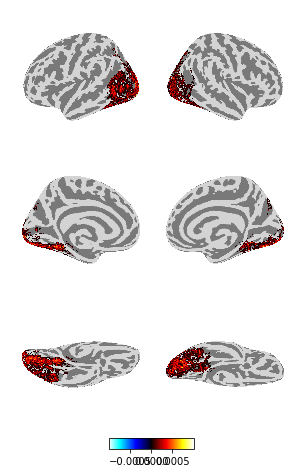

In [11]:
def set_values_to_zero(arr, th=0.001):
    arr[arr > th] = 0
    return arr

# Set values smaller than 0.001 to zero
masked_p_values = set_values_to_zero(p_value)
masked_p_values_brain = np.nan_to_num(masked_p_values.reshape((182, 218, 182)))

volume = convert_ndarray_to_nifti1image(masked_p_values_brain)

fig, _ = nilearn.plotting.plot_img_on_surf(
    volume,
    views=["lateral", "medial", "ventral"],
    hemispheres=["left", "right"],
    colorbar=True,
    inflate=True,
    surf_mesh='fsaverage',
    threshold=np.finfo(np.float32).resolution,
    symmetric_cbarbool='auto',
)
fig.savefig('significant_p_values',dpi=300)

# Plotting Brain for Visualization

In [2]:
def process_data_to_plot(data):

    #data = xr.open_dataset(scores_path,engine='h5netcdf')
    #data = data.where(data.subject==subject,drop=True)
    data = data.drop_vars(["subject",'region','name']).to_array()
    data.x.values = data.x.values.astype(int)
    data.y.values = data.y.values.astype(int)
    data.z.values = data.z.values.astype(int)
    data = data.drop('variable').squeeze()
    
    return data

In [3]:
resolution = '1pt8mm'      
interpolation_type = 'nearest'
colors = ['lightcoral','lightcoral']
custom_cmap = LinearSegmentedColormap.from_list('CustomMap', colors) 


subject = 0
regions = ['ventral visual stream']

In [ ]:
scores_list = []
for region in regions:
    data = xr.open_dataset(f'/data/atlas/.cache/encoding_scores_torch/expansion_3000_dataset=naturalscenes_{region}')
    data = data.where(data.subject == subject,drop=True)
    scores_list.append(data)
scores = xr.concat(scores_list, dim='neuroid')



alexnet_mni = transform_volume_to_mni(
    data=reshape_dataarray_to_brain(
        data=process_data_to_plot(scores),
        subject=subject,
        resolution=resolution,
    ),
    subject=subject,
    source_space=f"func{resolution[:-2]}",
    interpolation_type=interpolation_type,
)




brain_region = np.where(alexnet_mni > 0, 1,0)
volume = convert_ndarray_to_nifti1image(brain_region)

fig, _ = nilearn.plotting.plot_img_on_surf(
    volume,
    views=["lateral", "medial", "ventral"],
    hemispheres=["left", "right"],
    colorbar=True,
    inflate=True,
    surf_mesh='fsaverage',
    threshold=np.finfo(np.float32).resolution,
    symmetric_cbarbool='auto',
    cmap = custom_cmap, 
    vmax = 1
)
fig.savefig(f'just_brain_{regions}',dpi=300,transparent=True)

2024-01-11 20:37:50.613 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:113 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz instead of downloading nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz from S3 bucket natural-scenes-dataset
2024-01-11 20:37:50.624 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:113 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz instead of downloading nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz from S3 bucket natural-scenes-dataset
